# Ein erster CNN Versuch

In diesem Notebook wird ein erster Versuch unternommen das Problem mit einem CNN zu lösen. 

Die üblich Architektur benutzt dabei eine Feature-Extraktion mit Convolutional-Layern, gefolgt von ein paar Schichten von Fully-connected Layern. Diese Architektur wurde unter anderem von AlexNet bekannt gemacht: https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networ

![](https://qph.fs.quoracdn.net/main-qimg-9b3d3424df138ad5d7a87506dfddbc94)

Im ersten Schritt werden wieder die relevanten Packages importiert und Variablen definiert. 

Zusätzlich zu den bereits eingeführten Packages, importieren  wie einige Keras Packages welche es uns erlauben Modelle zu bauen.

In [1]:
from keras import models
from keras import layers

from keras.preprocessing.image import ImageDataGenerator

from keras import optimizers

import pylab as pl


TRAINSET = 'Cat_Dog_data/train'
TESTSET = 'Cat_Dog_data/test'

TARGET_SIZE = (150,150)
BATCH_SIZE = 16

Using TensorFlow backend.


In [2]:
# load data

image_datagen_train = ImageDataGenerator(rescale=1./255)

image_flow_from_directory_train = image_datagen_train.flow_from_directory(TRAINSET,
                                                             target_size=TARGET_SIZE,
                                                             color_mode='rgb',
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='binary')

image_datagen_test = ImageDataGenerator(rescale=1./255)

image_flow_from_directory_test = image_datagen_test.flow_from_directory(TESTSET,
                                                             target_size=TARGET_SIZE,
                                                             color_mode='rgb',
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='binary')

Found 22500 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In der nächsten Zelle wird das eigentlich Modell definiert. Dieses setzt sich aus einem Faltungsteil zur Feature-Extraktion und einem Fully-connected Teil zur Klassifikation von Hund oder Katze aus den extrahierten Features zusammen.



---

## Feature-Extraktion

Die Faltungsbasis setzt sich aus mehreren Schichten zusammen. Die einzelnen Schichten sind dabei wie folgt:



```
model.add(layers.Conv2D(Anzahl_Feature_Maps, Größe_des_Faltungskernels, activation='Wahl_der_Aktivierungsfunktion'))
model.add(layers.MaxPooling2D(Größe_des_Poolings))
```

Die hinteren Schichten haben kleine rezeptive Flächen, aber dafür mehr Feature Maps, bis in der letzten Schicht alle Feature in einen Vektor eingetragen werden

### Aktivierungs-Funktion

Als Aktivierungsfunktion für CNNs habt sich die Rectified-Linear-Unit sehr bewährt. Diese sieht wie folgt aus:

<img src=https://cdn-images-1.medium.com/max/1600/1*DfMRHwxY1gyyDmrIAd-gjQ.png width="500">

### Max-Pooling

Da in CNNs die genaue Position eines Features irrelevant ist, lässt sich die Performance des Modells stark verbesser indem wir einen Teil der Informationen vernächlässigen. Die passiert durch sogenanntes Max-Pooling wie im folgenden Bild dargestellt.


<img src=https://qph.fs.quoracdn.net/main-qimg-8afedfb2f82f279781bfefa269bc6a90.webp width="500">

Max-Pooling erlaubt eine starke Reduzierung der Netzgröße ohne dabei die Genauigkeit signifikant zu reduzieren.


---

## Fully-Connected Schicht

Die Fully-Connceted Schicht erhält als Input einen Vektor von Features welche von der Faltungsbasis extrahiert wurden. Als Output soll sie nun einen Wert zwischen 0 und 1 ausgeben, wobei 0 Katze entsprich und 1 Hund. Ein solches Problem wird als binäre Klassifikation bezeichnet.

Die Schichten werden dabei wie folgt angebunden:

```
model.add(layers.Dense(Anzahl_der_Neuronen_in_der_Schicht,activation='sigmoid'))
```

Die letzte Schicht hat dabei nur ein Neuron (da wir als Output nur den Bereich [0,1] wollen).

### Aktivierungs-Funktion

Als Aktivierungsfunktion für eine binäre Klassifikation bietet sich die Sigmoid-Funktion an, welche alle Inputs auf den Bereich [0,1] mapt.

<img src=https://i.stack.imgur.com/VDOBN.png width="500">




In [3]:
# define model

model = models.Sequential()

# feature extraction

model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(TARGET_SIZE[0],TARGET_SIZE[1],3)))
model.add(layers.Conv2D(32,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.Conv2D(128,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(256,(3,3), activation='relu'))
model.add(layers.Conv2D(256,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())

# Fully connected layers

model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 146, 146, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 69, 69, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 34, 34, 64)        0         
_________________________________________________________________
conv

Im nächsten Schritt soll das Modell assembliert werden. Dabei werden von Keras alle Gewichte mit einem zufälligen Wert initialisiert. 

Es muss zunächst eine Loss-Funktion und ein Optimierungsalgorithmus vorgegeben werden, welche im Folgenden genauer beschrieben werden.

## Loss Funktion

Die Loss Funktion bestimmt wie genau der Fehler bestimmt wird. Im Fall einer binären Klassifikation bietet sich die binäre Crossentropy an. Diese misst wie sehr die Wahrscheinlichkeitsverteilung des Ausgangs unseres Modells, mit der Wahrscheinlichkeitsverteilung des Testsets übereinstimmt. Sie ist minimal für den Fall das diese identisch sind.

## Optimierungsalgorthimus

Das klassische Mini-Batch Stochastic Gradient Descent hat einige Nachteile. So wurden über die Zeit einige adaptive Optimierungsverfahren entwickelt, welche die Lernrate adaptiv anpassen.

Ein toller, optischer Vergleich verschiedener Optimierungsalgorithmen für Deep Learning ist [hier](https://imgur.com/a/Hqolp#NKsFHJb)
  gegeben.
  
Eine genaue Einführung würde weit über den Umfang dieses Kurses hinaus gehen. In diesem Beispiel wird RMSprop verwendet, mit einer Lernrate von >5e-5.



In [0]:
# assemble model

model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

Als letzter Schritt wird das Netz mit den Trainingsdaten trainiert. Dabei werden aus Zeitgründen nicht (wie üblich) pro Epoche Anzahl_Bilder/Batch_Size gemacht, sondern lediglich einige wenige. In jeder Epoche wird das Modell danach auf dem Test-Set getestet.

In [5]:
# train model

history = model.fit_generator(image_flow_from_directory_train,
                   steps_per_epoch=150,
                   epochs=10,
                   validation_data=image_flow_from_directory_test,
                   validation_steps=50,
                   verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
150/150 [==============================] - 18s 119ms/step - loss: 0.6899 - acc: 0.5304 - val_loss: 0.6802 - val_acc: 0.5787
Epoch 2/10
150/150 [==============================] - 14s 94ms/step - loss: 0.6749 - acc: 0.5825 - val_loss: 0.6424 - val_acc: 0.6338
Epoch 3/10
150/150 [==============================] - 14s 94ms/step - loss: 0.6486 - acc: 0.6204 - val_loss: 0.7191 - val_acc: 0.5850
Epoch 4/10
150/150 [==============================] - 14s 94ms/step - loss: 0.6296 - acc: 0.6454 - val_loss: 0.6084 - val_acc: 0.6485
Epoch 5/10
150/150 [==============================] - 14s 93ms/step - loss: 0.6111 - acc: 0.6646 - val_loss: 0.6230 - val_acc: 0.6400
Epoch 6/10
150/150 [==============================] - 14s 93ms/step - loss: 0.5874 - acc: 0.6813 - val_loss: 0.7746 - val_acc: 0.6075
Epoch 7/10
150/150 [==============================] - 14s 93ms/step - loss: 0.5938 - acc: 0.6783 - val_loss: 0.5678 - val_acc: 0.7234
Epoch 8/10
15

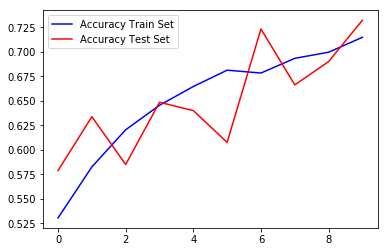

In [6]:
# plot history

pl.figure()
pl.plot(history.history['acc'],'b',label='Accuracy Train Set')
pl.plot(history.history['val_acc'],'r',label='Accuracy Test Set')

pl.legend()